In [1]:
#deal with tensors
import torch   
import torch.nn as nn

from sklearn.metrics import accuracy_score

#handling text data
from torchtext.legacy import data

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

In [2]:
# Import Data

test = pd.read_json("./minidata/trainDATASET.json", lines=True)
train = pd.read_json("./minidata/trainDATASET.json", lines=True)

In [3]:
# Shape of dataset
train.shape

(4, 2)

In [4]:
train.head()

,description,tag
0,eBay O*14-xxxxx-03975 - Visa Purchase - Receip...,random
1,ROLLD KOTARA - Visa Purchase - Receipt ${recei...,food
2,Amazon Australia Services - Visa Purchase - Re...,other
3,AMAZON MKTPLC AU - Visa Purchase - Receipt ${r...,other


In [5]:
# to clean data
def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [6]:
train["description"]=normalise_text(train["description"])

C:\Users\Moosa\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
C:\Users\Moosa\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
C:\Users\Moosa\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
C:\Users\Moosa\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [7]:
train['description'].head()

0    ebay o 14 xxxxx 03975 visa purchase receipt re...
1    rolld kotara visa purchase receipt receipt no ...
2    amazon australia services visa purchase receip...
3    amazon mktplc au visa purchase receipt receipt...
Name: description, dtype: object

In [8]:
# split data into train and validation 
train_df, valid_df = train_test_split(train)

In [9]:
train_df.head()

,description,tag
1,rolld kotara visa purchase receipt receipt no ...,food
0,ebay o 14 xxxxx 03975 visa purchase receipt re...,random
2,amazon australia services visa purchase receip...,other


In [10]:
valid_df.head()

,description,tag
3,amazon mktplc au visa purchase receipt receipt...,other


In [11]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
DESCRIPTION = data.Field(tokenize = 'spacy', include_lengths = True)
TAG = data.LabelField(dtype = torch.float)

In [13]:
# create a dictionary representing the dataset
fields = {
  'description': ('description', DESCRIPTION),
  'tag': ('tag', TAG)
}

In [14]:
# load the dataset in json format
train_ds, test_ds = data.TabularDataset.splits(
  path = 'mydata',
  train = 'smaller-dataset.json',
  test = 'modified-smaller-dataset.json',
  format = 'json',
  fields = fields
)

In [15]:
# Lets look at a random example
print(vars(train_ds[1]))

# Check the type 
print(type(train_ds[1]))

{'description': ['AMAZON', 'MKTPLC', 'AU', '-', 'Visa', 'Purchase', '-', 'Receipt', '$', '{', 'receipt_no', '}', 'SYDNEY', 'SOUTH', 'trans_date', '}', '2022', 'Card', '491684xxxxxx8665'], 'tag': 'other'}
<class 'torchtext.legacy.data.example.Example'>


In [16]:
MAX_VOCAB_SIZE = 25000

DESCRIPTION.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_)

In [17]:
TAG.build_vocab(train_ds)

In [18]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 2

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, test_ds), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.tag),
    sort=False,
    sort_within_batch=True,
    device = device)

for batch in train_iterator:
    print(batch.description)
    print(batch.tag)

(tensor([[14, 16],
        [20, 17],
        [15, 23],
        [ 2,  2],
        [10, 10],
        [ 8,  8],
        [ 2,  2],
        [ 9,  9],
        [ 4,  4],
        [ 5,  5],
        [11, 11],
        [ 3,  3],
        [22, 19],
        [21, 18],
        [12,  4],
        [ 3,  5],
        [13, 12],
        [ 7,  3],
        [ 6,  7],
        [ 1,  6]]), tensor([19, 20]))
tensor([0., 0.])


In [19]:
# Hyperparameters
num_epochs = 25
learning_rate = 0.001

INPUT_DIM = len(DESCRIPTION.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = DESCRIPTION.vocab.stoi[DESCRIPTION.pad_token] # padding

In [20]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

In [21]:
#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [22]:
pretrained_embeddings = DESCRIPTION.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([24, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5248, -0.3196, -0.1190,  ..., -0.0464,  0.5881,  1.5755],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [23]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5248, -0.3196, -0.1190,  ..., -0.0464,  0.5881,  1.5755],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [24]:
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [26]:
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.description
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.tag)
        acc = binary_accuracy(predictions, batch.tag)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.tag)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [28]:
# t = time.time()
# loss=[]
# acc=[]
# val_acc=[]
# 
# for epoch in range(num_epochs):
#     
#     train_loss, train_acc = train(model, train_iterator)
#     valid_acc = evaluate(model, valid_iterator)
#     
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Acc: {valid_acc*100:.2f}%')
#     
#     loss.append(train_loss)
#     acc.append(train_acc)
#     val_acc.append(valid_acc)
#     
# print(f'time:{time.time()-t:.3f}')

In [29]:
class AmazonLSTMRNN(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers
               , bidirectional, dropout, pad_idx):
    super(AmazonLSTMRNN, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim=embedding_size, padding_idx=pad_idx)
    self.lstm = nn.LSTM(embedding_size, hidden_size=hidden_size, 
                        bidirectional=bidirectional, num_layers=num_layers,
                        dropout=dropout)
    self.fc = nn.Linear(hidden_size * 2, out_features=output_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, text, text_lengths):
    embedded = self.dropout(self.embedding(text))
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False)
    packed_output, (h_0, c_0) = self.rnn(packed_embedded)
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    h_0 = self.dropout(torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim = 1))
    return self.fc(h_0)


INPUT_DIM = len(DESCRIPTION.vocab) # # 25002
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = DESCRIPTION.vocab.stoi[DESCRIPTION.pad_token] # 0
amazon_model = AmazonLSTMRNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(amazon_model.parameters())
amazon_model = amazon_model.to(device)
criterion = criterion.to(device)

In [30]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.description
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.tag)
        acc = binary_accuracy(predictions, batch.tag)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [31]:
t = time.time()
acc=[]
loss=[]
N_EPOCHS = 5
best_valid_loss = float('inf')
valid_loss = 5000

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    end_time = time.time()
    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
    #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    
print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.753 | Train Acc: 0.00%
	Train Loss: 0.723 | Train Acc: 50.00%
	Train Loss: 0.693 | Train Acc: 100.00%
	Train Loss: 0.693 | Train Acc: 100.00%
	Train Loss: 0.757 | Train Acc: 0.00%
time:0.410


<function matplotlib.pyplot.show(close=None, block=None)>

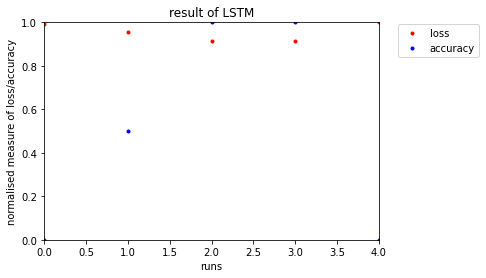

In [32]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len, default=0), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss, default=0)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
#plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [33]:
model.eval()

LSTM_net(
  (embedding): Embedding(24, 200, padding_idx=1)
  (rnn): LSTM(200, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [44]:
import spacy 
nlp = spacy.load("en")

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [DESCRIPTION.vocab.stoi[t] for t in tokenized]   #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return prediction.item()  

In [35]:
#make predictions
predict(model, "ebay")

0.09075460582971573

In [39]:
import pickle

data = {"model": model, "description": DESCRIPTION}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)

In [40]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

model_loaded = data["model"]
DESCRIPTION = data["description"]

In [43]:
y_pred = predict(model, "ebay")
y_pred

0.09075460582971573